# Exploratory Data Analysis for Pair Trading: CROISSANTS and JAMS

This notebook explores the potential for pair trading between CROISSANTS and JAMS by analyzing their price relationships, correlations, and spread characteristics.

In [1]:
# Import necessary libraries
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from importlib import reload
from scipy import stats
from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.regression.linear_model import OLS

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')

# Add data_utils to path
sys.path.append(os.path.abspath('../data_utils'))
try:
    import util_minimal
    print("Successfully imported util_minimal")
except ImportError:
    print("Could not import util_minimal")

# Try to import backtester package
try:
    sys.path.append(os.path.abspath('../../'))
    from backtester import get_price_data
    print("Successfully imported backtester.get_price_data")
except ImportError:
    print("Could not import backtester")

Successfully imported util_minimal
Successfully imported backtester.get_price_data


## 1. Load Data

First, let's load the price data for Round 2, focusing on CROISSANTS and JAMS.

In [2]:
# Define products we need
products = ['CROISSANTS', 'JAMS']
product_data = {product: pd.DataFrame() for product in products}

# Try to load data using backtester package
has_data = False
try:
    for product in products:
        print(f"Loading {product} data using backtester...")
        product_data[product] = get_price_data(product, 2)
        print(f"Loaded {len(product_data[product])} rows of {product} data")
    has_data = all(len(data) > 0 for data in product_data.values())
    if has_data:
        print("Successfully loaded all required data using backtester")
except Exception as e:
    print(f"Error loading data using backtester: {e}")
    has_data = False

# If backtester package didn't work, try using util module
if not has_data:
    print("Trying to load data using util module...")
    try:
        reload(util_minimal)
        dm2p = util_minimal.load_all_price_data(2)
        print(f"Loaded {len(dm2p)} rows of data")
        
        # Display the first few rows
        print("\nFirst few rows of data:")
        display(dm2p.head())
        
        # Filter for each product
        for product in products:
            if product in dm2p['product'].unique():
                product_data[product] = dm2p[dm2p['product'] == product].copy()
                print(f"Filtered {len(product_data[product])} rows of {product} data")
            else:
                print(f"No {product} data found")
                product_data[product] = pd.DataFrame()
        
        has_data = all(len(data) > 0 for data in product_data.values())
        if has_data:
            print("Successfully loaded all required data using util module")
    except Exception as e:
        print(f"Error loading data using util module: {e}")
        has_data = False

Loading CROISSANTS data using backtester...
Loading real data for CROISSANTS from round 2...
Data for Round 2, Day -2 not found. Skipping.
Found data file at ../../../Prosperity 3 Data/Round 2/prices_round_2_day_-1.csv
Found data file at ../../../Prosperity 3 Data/Round 2/prices_round_2_day_0.csv
Found data file at ../../../Prosperity 3 Data/Round 2/prices_round_2_day_1.csv
Successfully loaded real data with 30000 rows
Loaded 30000 rows of CROISSANTS data
Loading JAMS data using backtester...
Loading real data for JAMS from round 2...
Data for Round 2, Day -2 not found. Skipping.
Found data file at ../../../Prosperity 3 Data/Round 2/prices_round_2_day_-1.csv
Found data file at ../../../Prosperity 3 Data/Round 2/prices_round_2_day_0.csv
Found data file at ../../../Prosperity 3 Data/Round 2/prices_round_2_day_1.csv
Successfully loaded real data with 30000 rows
Loaded 30000 rows of JAMS data
Successfully loaded all required data using backtester


## 2. Prepare Data

Now let's prepare the data for analysis by calculating VWAP prices and aligning the time series.

In [3]:
# Function to calculate VWAP for all products
def calculate_vwap(product_data):
    vwap_prices = {}
    for product, data in product_data.items():
        if len(data) > 0:
            try:
                # Try to use get_vwap from util_minimal if available
                vwap = util_minimal.get_vwap(data, product)
                vwap_prices[product] = vwap
                print(f"Calculated VWAP for {product} using util_minimal.get_vwap")
            except Exception as e:
                print(f"Error using util_minimal.get_vwap for {product}: {e}")
                
                # Calculate VWAP manually
                try:
                    # Calculate mid price if not already present
                    if 'mid_price' not in data.columns:
                        data['mid_price'] = (data['ask_price_1'] + data['bid_price_1']) / 2
                    
                    # Calculate volume if not already present
                    if 'total_volume' not in data.columns:
                        volume_cols = ['ask_volume_1', 'ask_volume_2', 'ask_volume_3', 'bid_volume_1', 'bid_volume_2', 'bid_volume_3']
                        data['total_volume'] = data[volume_cols].sum(axis=1)
                    
                    # Calculate VWAP
                    data['price_volume'] = data['mid_price'] * data['total_volume']
                    
                    # Group by timestamp if available, otherwise use index
                    if 'timestamp' in data.columns:
                        data_grouped = data.groupby('timestamp')
                        vwap = data_grouped['price_volume'].sum() / data_grouped['total_volume'].sum()
                    else:
                        data_grouped = data.groupby(data.index)
                        vwap = data_grouped['price_volume'].sum() / data_grouped['total_volume'].sum()
                    
                    vwap_prices[product] = vwap
                    print(f"Calculated VWAP for {product} manually")
                except Exception as e:
                    print(f"Error calculating manual VWAP for {product}: {e}")
                    
                    # Fall back to mid price if VWAP calculation fails
                    if 'mid_price' in data.columns:
                        if 'timestamp' in data.columns:
                            vwap_prices[product] = data.set_index('timestamp')['mid_price']
                        else:
                            vwap_prices[product] = data['mid_price']
                        print(f"Falling back to mid price for {product}")
    
    return vwap_prices

# Function to prepare price data for analysis
def prepare_price_data(vwap_prices):
    # Create a common index for all products
    all_indices = set()
    for product, prices in vwap_prices.items():
        all_indices.update(prices.index)
    common_index = sorted(all_indices)
    
    # Reindex all price series to the common index and forward fill missing values
    reindexed_prices = {}
    for product, prices in vwap_prices.items():
        reindexed_prices[product] = prices.reindex(common_index).ffill().bfill()
    
    return reindexed_prices, common_index

# Calculate VWAP and prepare data
if has_data:
    try:
        # Calculate VWAP
        vwap_prices = calculate_vwap(product_data)
        print(f"Calculated VWAP for {len(vwap_prices)} products")
        
        # Prepare price data
        reindexed_prices, common_index = prepare_price_data(vwap_prices)
        print(f"Prepared price data with {len(common_index)} timestamps")
        
        # Create a DataFrame with aligned price series
        price_df = pd.DataFrame({
            'CROISSANTS': reindexed_prices['CROISSANTS'],
            'JAMS': reindexed_prices['JAMS']
        })
        
        # Display basic information about the price series
        print("\nPrice statistics:")
        for product in products:
            print(f"\n{product}:")
            print(f"Mean: {price_df[product].mean():.2f}")
            print(f"Median: {price_df[product].median():.2f}")
            print(f"Min: {price_df[product].min():.2f}")
            print(f"Max: {price_df[product].max():.2f}")
            print(f"Standard deviation: {price_df[product].std():.2f}")
        
        # Display the first few rows of the price DataFrame
        print("\nFirst few rows of price DataFrame:")
        display(price_df.head())
        
        # Calculate returns
        returns_df = price_df.pct_change().dropna()
        
        # Display basic information about the returns
        print("\nReturns statistics:")
        for product in products:
            print(f"\n{product} returns:")
            print(f"Mean: {returns_df[product].mean():.6f}")
            print(f"Median: {returns_df[product].median():.6f}")
            print(f"Min: {returns_df[product].min():.6f}")
            print(f"Max: {returns_df[product].max():.6f}")
            print(f"Standard deviation: {returns_df[product].std():.6f}")
        
        # Display the first few rows of the returns DataFrame
        print("\nFirst few rows of returns DataFrame:")
        display(returns_df.head())
    except Exception as e:
        print(f"Error preparing data: {e}")
else:
    print("Cannot prepare data due to missing price data")

Calculated VWAP for CROISSANTS using util_minimal.get_vwap
Calculated VWAP for JAMS using util_minimal.get_vwap
Calculated VWAP for 2 products
Prepared price data with 30000 timestamps

Price statistics:

CROISSANTS:
Mean: 4297.84
Median: 4304.50
Min: 4251.00
Max: 4340.50
Standard deviation: 23.78

JAMS:
Mean: 6593.32
Median: 6610.00
Min: 6498.50
Max: 6702.50
Standard deviation: 59.55

First few rows of price DataFrame:


,CROISSANTS,JAMS
timestamp,,
0,4304.5,6670.5
100,4304.5,6670.5
200,4304.5,6671.0
300,4304.5,6672.0
400,4305.5,6672.0



Returns statistics:

CROISSANTS returns:
Mean: -0.000000
Median: 0.000000
Min: -0.001843
Max: 0.000836
Standard deviation: 0.000075

JAMS returns:
Mean: -0.000001
Median: 0.000000
Min: -0.000750
Max: 0.000841
Standard deviation: 0.000076

First few rows of returns DataFrame:


,CROISSANTS,JAMS
timestamp,,
100,0.000000,0.000000
200,0.000000,0.000075
300,0.000000,0.000150
400,0.000232,0.000000
500,0.000000,0.000000


## 3. Visualize Price Data

Let's visualize the price data to get a better understanding of the relationship between CROISSANTS and JAMS.

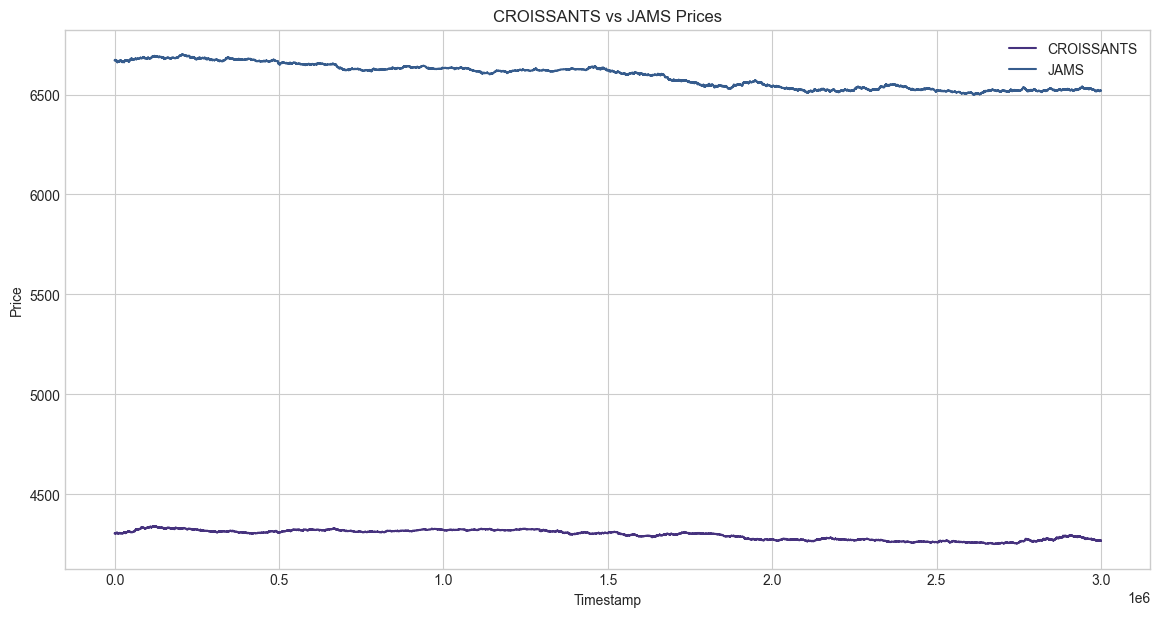

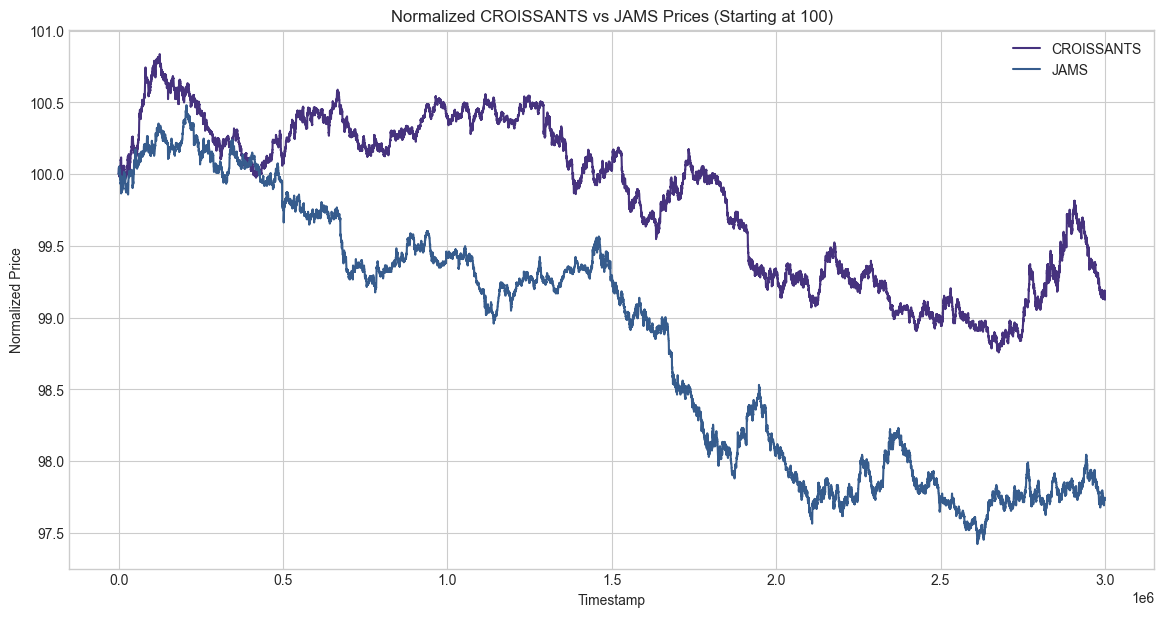

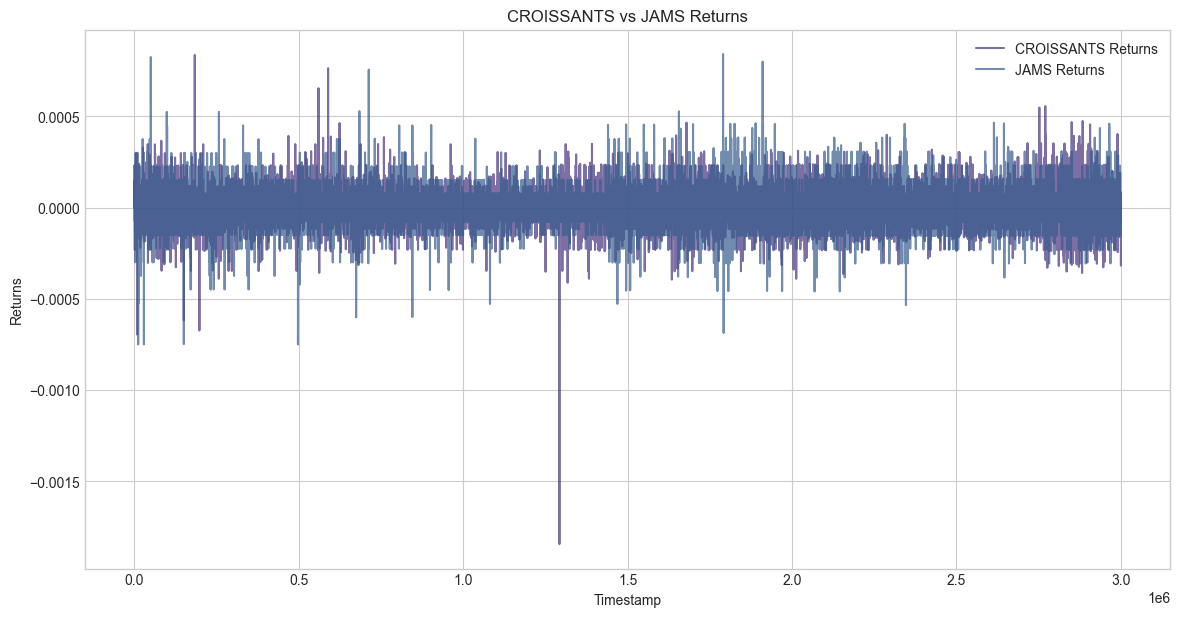

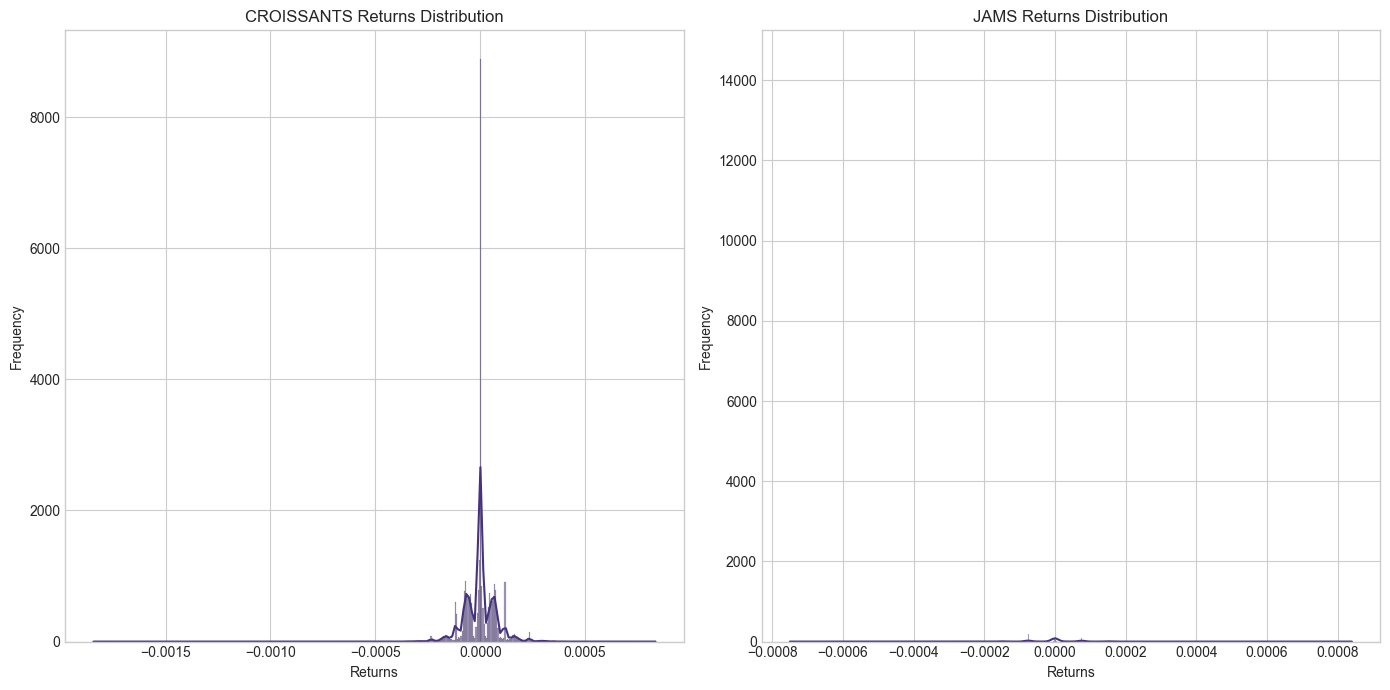

In [4]:
# Visualize price data
if 'price_df' in locals() and len(price_df) > 0:
    try:
        # Plot the price series
        plt.figure(figsize=(14, 7))
        plt.plot(price_df.index, price_df['CROISSANTS'], label='CROISSANTS')
        plt.plot(price_df.index, price_df['JAMS'], label='JAMS')
        plt.title('CROISSANTS vs JAMS Prices')
        plt.xlabel('Timestamp')
        plt.ylabel('Price')
        plt.legend()
        plt.grid(True)
        plt.show()
        
        # Plot the normalized price series (starting at 100)
        normalized_prices = price_df.copy()
        for col in normalized_prices.columns:
            normalized_prices[col] = normalized_prices[col] / normalized_prices[col].iloc[0] * 100
        
        plt.figure(figsize=(14, 7))
        plt.plot(normalized_prices.index, normalized_prices['CROISSANTS'], label='CROISSANTS')
        plt.plot(normalized_prices.index, normalized_prices['JAMS'], label='JAMS')
        plt.title('Normalized CROISSANTS vs JAMS Prices (Starting at 100)')
        plt.xlabel('Timestamp')
        plt.ylabel('Normalized Price')
        plt.legend()
        plt.grid(True)
        plt.show()
        
        # Plot the returns
        if 'returns_df' in locals() and len(returns_df) > 0:
            plt.figure(figsize=(14, 7))
            plt.plot(returns_df.index, returns_df['CROISSANTS'], label='CROISSANTS Returns', alpha=0.7)
            plt.plot(returns_df.index, returns_df['JAMS'], label='JAMS Returns', alpha=0.7)
            plt.title('CROISSANTS vs JAMS Returns')
            plt.xlabel('Timestamp')
            plt.ylabel('Returns')
            plt.legend()
            plt.grid(True)
            plt.show()
            
            # Plot the distribution of returns
            plt.figure(figsize=(14, 7))
            plt.subplot(1, 2, 1)
            sns.histplot(returns_df['CROISSANTS'], kde=True)
            plt.title('CROISSANTS Returns Distribution')
            plt.xlabel('Returns')
            plt.ylabel('Frequency')
            
            plt.subplot(1, 2, 2)
            sns.histplot(returns_df['JAMS'], kde=True)
            plt.title('JAMS Returns Distribution')
            plt.xlabel('Returns')
            plt.ylabel('Frequency')
            
            plt.tight_layout()
            plt.show()
    except Exception as e:
        print(f"Error visualizing price data: {e}")
else:
    print("Cannot visualize price data due to missing data")

## 4. Correlation Analysis

Now let's analyze the correlation between CROISSANTS and JAMS to assess their potential for pair trading.

Price correlation between CROISSANTS and JAMS: 0.8854
Returns correlation between CROISSANTS and JAMS: 0.0086


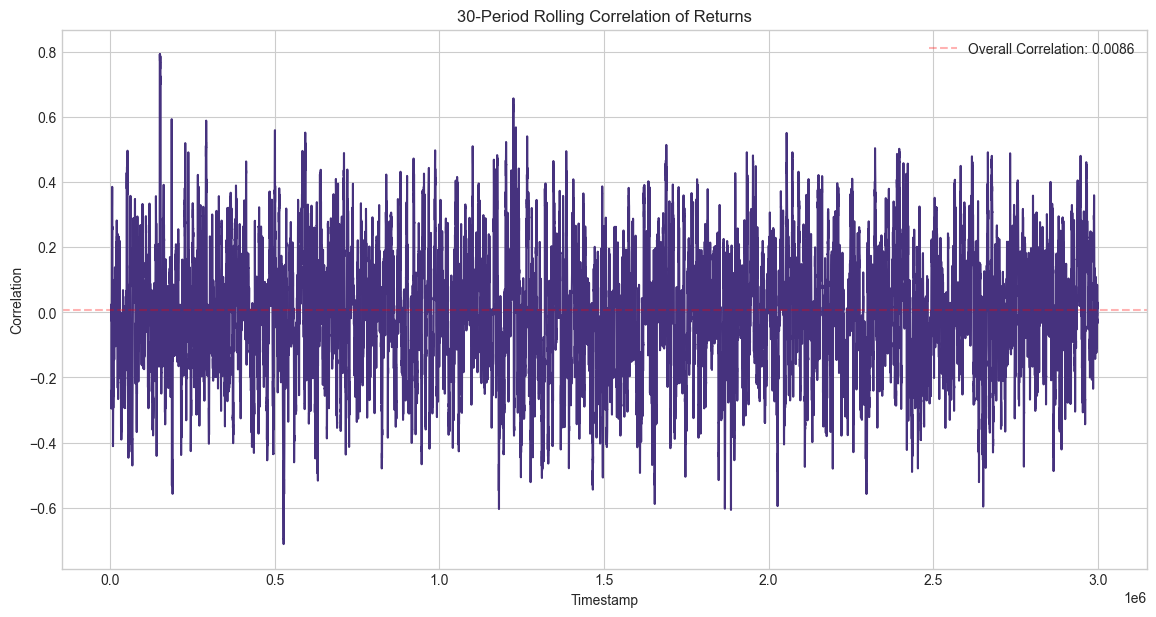

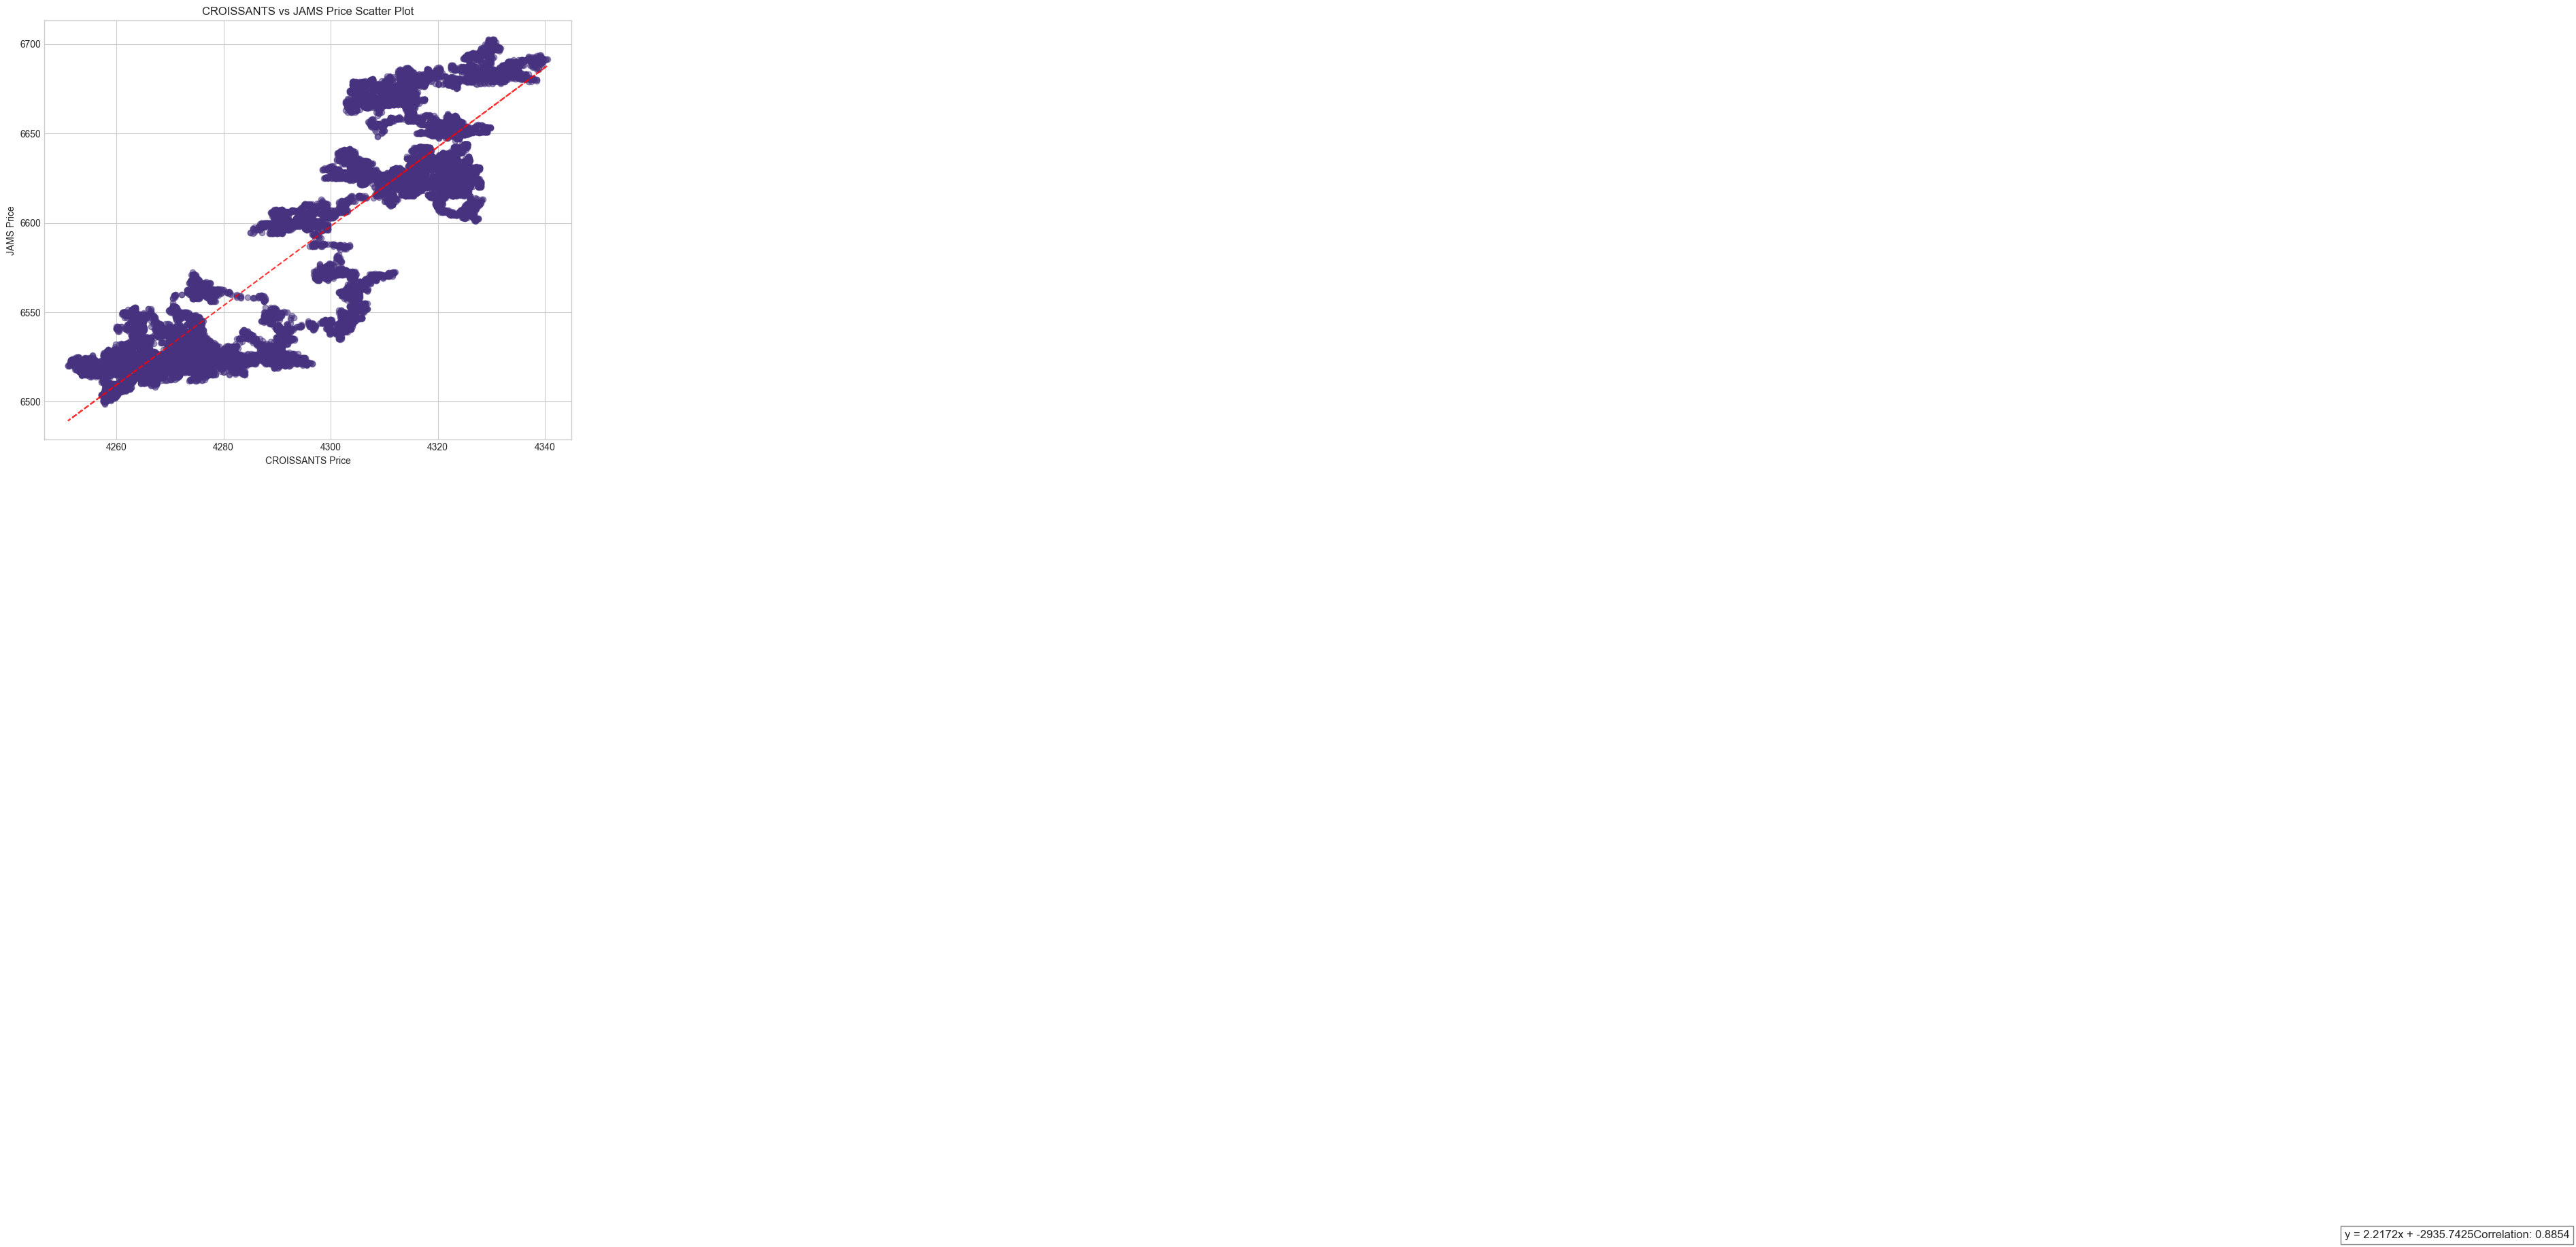

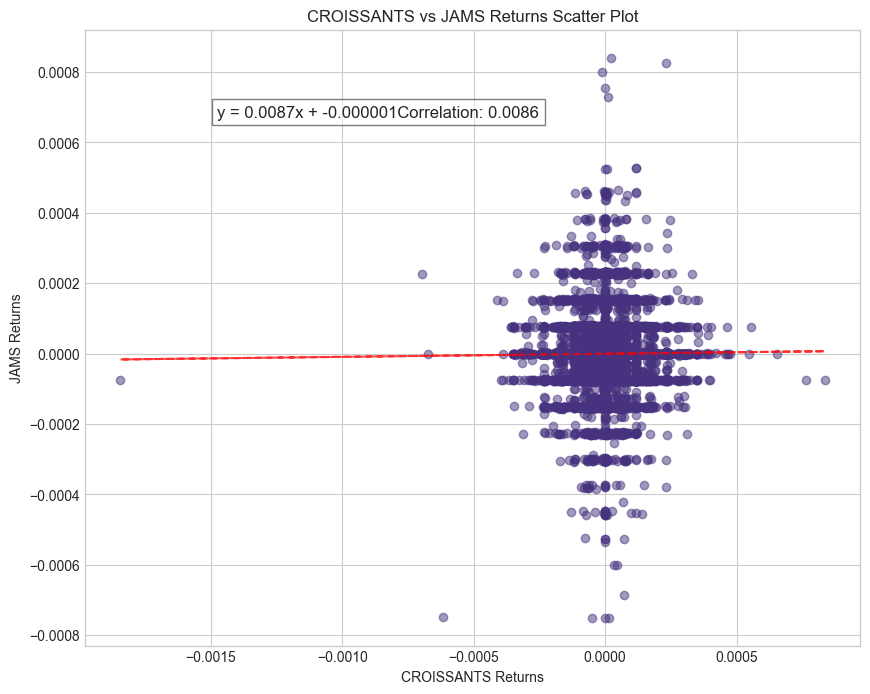

In [7]:
# Correlation analysis
if 'price_df' in locals() and 'returns_df' in locals() and len(price_df) > 0 and len(returns_df) > 0:
    try:
        # Calculate price correlation
        price_correlation = price_df['CROISSANTS'].corr(price_df['JAMS'])
        print(f"Price correlation between CROISSANTS and JAMS: {price_correlation:.4f}")
        
        # Calculate returns correlation
        returns_correlation = returns_df['CROISSANTS'].corr(returns_df['JAMS'])
        print(f"Returns correlation between CROISSANTS and JAMS: {returns_correlation:.4f}")
        
        # Calculate rolling correlation of returns (30-period window)
        rolling_corr = returns_df['CROISSANTS'].rolling(window=30).corr(returns_df['JAMS'])
        
        # Plot rolling correlation
        plt.figure(figsize=(14, 7))
        plt.plot(rolling_corr.index, rolling_corr.values)
        plt.axhline(y=returns_correlation, color='r', linestyle='--', alpha=0.3, label=f'Overall Correlation: {returns_correlation:.4f}')
        plt.title('30-Period Rolling Correlation of Returns')
        plt.xlabel('Timestamp')
        plt.ylabel('Correlation')
        plt.legend()
        plt.grid(True)
        plt.show()
        
        # Create a scatter plot of prices
        plt.figure(figsize=(10, 8))
        plt.scatter(price_df['CROISSANTS'], price_df['JAMS'], alpha=0.5)
        plt.title('CROISSANTS vs JAMS Price Scatter Plot')
        plt.xlabel('CROISSANTS Price')
        plt.ylabel('JAMS Price')
        
        # Add regression line
        z = np.polyfit(price_df['CROISSANTS'], price_df['JAMS'], 1)
        p = np.poly1d(z)
        plt.plot(price_df['CROISSANTS'], p(price_df['CROISSANTS']), 'r--', alpha=0.8)
        plt.text(price_df['CROISSANTS'].min() * 1.1, price_df['JAMS'].max() * 0.9, 
                 f'y = {z[0]:.4f}x + {z[1]:.4f}Correlation: {price_correlation:.4f}', 
                 fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
        
        plt.grid(True)
        plt.show()
        
        # Create a scatter plot of returns
        plt.figure(figsize=(10, 8))
        plt.scatter(returns_df['CROISSANTS'], returns_df['JAMS'], alpha=0.5)
        plt.title('CROISSANTS vs JAMS Returns Scatter Plot')
        plt.xlabel('CROISSANTS Returns')
        plt.ylabel('JAMS Returns')
        
        # Add regression line
        z = np.polyfit(returns_df['CROISSANTS'], returns_df['JAMS'], 1)
        p = np.poly1d(z)
        plt.plot(returns_df['CROISSANTS'], p(returns_df['CROISSANTS']), 'r--', alpha=0.8)
        plt.text(returns_df['CROISSANTS'].min() * 0.8, returns_df['JAMS'].max() * 0.8, 
                 f'y = {z[0]:.4f}x + {z[1]:.6f}Correlation: {returns_correlation:.4f}', 
                 fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
        
        plt.grid(True)
        plt.show()
    except Exception as e:
        print(f"Error performing correlation analysis: {e}")
else:
    print("Cannot perform correlation analysis due to missing data")

## 5. Cointegration Analysis

Now let's test for cointegration between CROISSANTS and JAMS to determine if they form a stationary pair.

Engle-Granger cointegration test:
Score: -3.1557
P-value: 0.0777
Failed to reject the null hypothesis of no cointegration at the 0.05 significance level.
This suggests that CROISSANTS and JAMS may not form a stationary pair.

Hedge ratio (CROISSANTS to JAMS): 1.5341
This means that 1 unit of CROISSANTS is approximately equivalent to 1.5341 units of JAMS.


C:\Users\fujos\AppData\Local\Temp\ipykernel_7068\1468135053.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio = results.params[0]


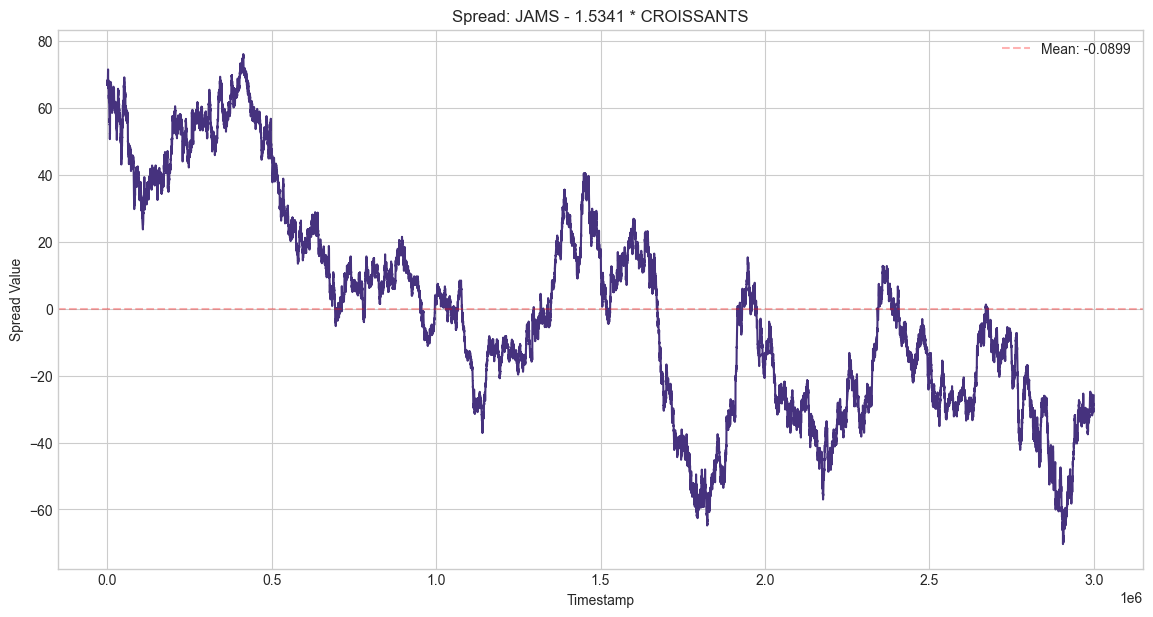


Augmented Dickey-Fuller test for spread stationarity:
ADF Statistic: -2.3807
P-value: 0.1473
Critical Values:
	1%: -3.4306
	5%: -2.8616
	10%: -2.5668

The spread is not stationary (fail to reject the null hypothesis).
This suggests that CROISSANTS and JAMS may not be suitable for pair trading.

Spread statistics:
Mean: -0.0899
Median: -2.7421
Min: -70.3462
Max: 76.1332
Standard deviation: 32.0965

Half-life of mean reversion: 2312.83 periods
This means that it takes approximately 2312.83 periods for the spread to revert halfway to its mean.


C:\Users\fujos\AppData\Local\Temp\ipykernel_7068\1468135053.py:76: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  half_life = -np.log(2) / results.params[0] if results.params[0] < 0 else float('inf')


In [9]:
# Cointegration analysis
if 'price_df' in locals() and len(price_df) > 0:
    try:
        # Perform Engle-Granger cointegration test
        score, pvalue, _ = coint(price_df['CROISSANTS'], price_df['JAMS'])
        print(f"Engle-Granger cointegration test:")
        print(f"Score: {score:.4f}")
        print(f"P-value: {pvalue:.4f}")
        
        # Interpret the results
        alpha = 0.05
        if pvalue < alpha:
            print(f"The series are cointegrated at the {alpha} significance level.")
            print("This suggests that CROISSANTS and JAMS may be suitable for pair trading.")
        else:
            print(f"Failed to reject the null hypothesis of no cointegration at the {alpha} significance level.")
            print("This suggests that CROISSANTS and JAMS may not form a stationary pair.")
        
        # Perform linear regression to find the hedge ratio
        model = OLS(price_df['JAMS'], price_df['CROISSANTS'])
        results = model.fit()
        hedge_ratio = results.params[0]
        
        print(f"\nHedge ratio (CROISSANTS to JAMS): {hedge_ratio:.4f}")
        print(f"This means that 1 unit of CROISSANTS is approximately equivalent to {hedge_ratio:.4f} units of JAMS.")
        
        # Calculate the spread
        spread = price_df['JAMS'] - hedge_ratio * price_df['CROISSANTS']
        
        # Plot the spread
        plt.figure(figsize=(14, 7))
        plt.plot(spread.index, spread.values)
        plt.axhline(y=spread.mean(), color='r', linestyle='--', alpha=0.3, label=f'Mean: {spread.mean():.4f}')
        plt.title(f'Spread: JAMS - {hedge_ratio:.4f} * CROISSANTS')
        plt.xlabel('Timestamp')
        plt.ylabel('Spread Value')
        plt.legend()
        plt.grid(True)
        plt.show()
        
        # Test the stationarity of the spread using Augmented Dickey-Fuller test
        adf_result = adfuller(spread.dropna())
        print(f"\nAugmented Dickey-Fuller test for spread stationarity:")
        print(f"ADF Statistic: {adf_result[0]:.4f}")
        print(f"P-value: {adf_result[1]:.4f}")
        
        # Print critical values
        print("Critical Values:")
        for key, value in adf_result[4].items():
            print(f"	{key}: {value:.4f}")
        
        # Interpret the results
        if adf_result[1] < 0.05:
            print("\nThe spread is stationary (reject the null hypothesis).")
            print("This confirms that CROISSANTS and JAMS may be suitable for pair trading.")
        else:
            print("\nThe spread is not stationary (fail to reject the null hypothesis).")
            print("This suggests that CROISSANTS and JAMS may not be suitable for pair trading.")
        
        # Calculate spread statistics
        print(f"\nSpread statistics:")
        print(f"Mean: {spread.mean():.4f}")
        print(f"Median: {spread.median():.4f}")
        print(f"Min: {spread.min():.4f}")
        print(f"Max: {spread.max():.4f}")
        print(f"Standard deviation: {spread.std():.4f}")
        
        # Calculate half-life of mean reversion
        spread_lag = spread.shift(1)
        spread_diff = spread - spread_lag
        spread_lag = spread_lag.dropna()
        spread_diff = spread_diff.dropna()
        
        model = OLS(spread_diff, spread_lag)
        results = model.fit()
        half_life = -np.log(2) / results.params[0] if results.params[0] < 0 else float('inf')
        
        print(f"\nHalf-life of mean reversion: {half_life:.2f} periods")
        if half_life < float('inf'):
            print(f"This means that it takes approximately {half_life:.2f} periods for the spread to revert halfway to its mean.")
        else:
            print("The spread does not exhibit mean-reverting behavior.")
    except Exception as e:
        print(f"Error performing cointegration analysis: {e}")
else:
    print("Cannot perform cointegration analysis due to missing data")

## 6. Z-Score Analysis

Now let's calculate the z-score of the spread to identify potential trading opportunities.

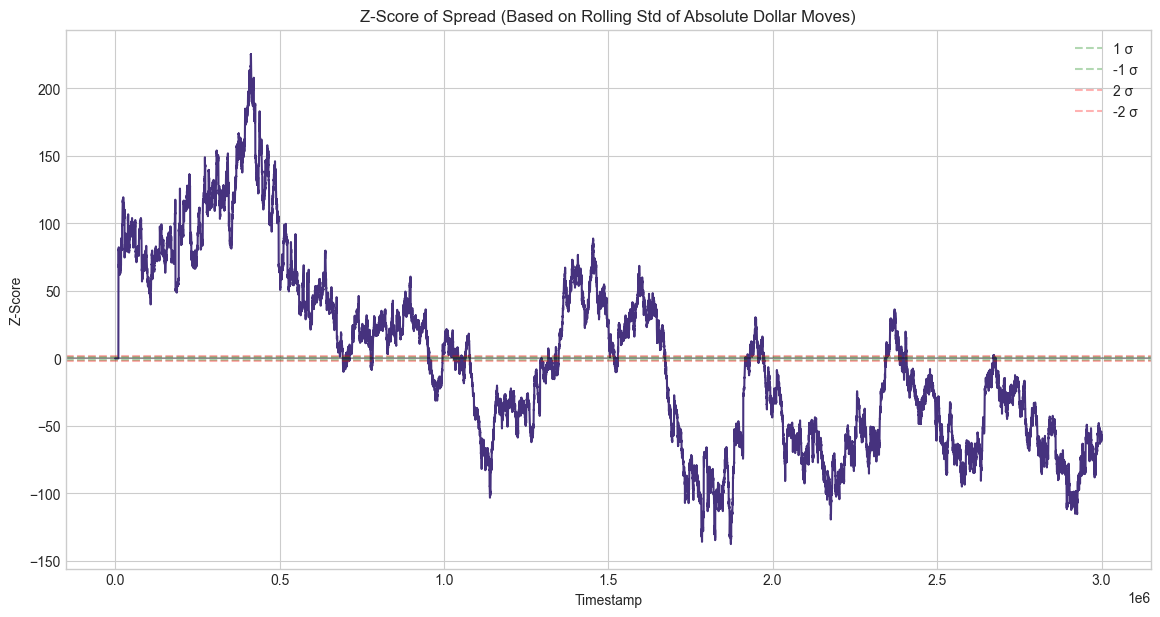

Z-score statistics:
Mean: -0.3490
Median: -5.6701
Min: -137.4609
Max: 225.2519
Standard deviation: 66.5655

Percentage of time z-score is above/below thresholds:
Above 1 σ: 46.29%
Below -1 σ: 52.30%
Above 1.5 σ: 46.12%
Below -1.5 σ: 52.16%
Above 2 σ: 45.88%
Below -2 σ: 51.82%
Above 2.5 σ: 45.69%
Below -2.5 σ: 51.61%
Above 3 σ: 45.50%
Below -3 σ: 51.27%


In [10]:
# Z-score analysis
if 'spread' in locals() and len(spread) > 0:
    try:
        # Calculate z-score (normalized spread)
        window = 100  # As specified in the requirements
        
        # Calculate absolute dollar moves of the spread
        spread_abs_move = spread.diff().abs()
        
        # Calculate rolling standard deviation of absolute dollar moves
        spread_roll_std = spread_abs_move.rolling(window=window).std()
        
        # Calculate z-score
        zscore = spread / spread_roll_std
        
        # Forward fill NaN values in z-score (due to rolling window)
        zscore = zscore.fillna(0)
        
        # Plot the z-score
        plt.figure(figsize=(14, 7))
        plt.plot(zscore.index, zscore.values)
        plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
        plt.axhline(y=1, color='g', linestyle='--', alpha=0.3, label='1 σ')
        plt.axhline(y=-1, color='g', linestyle='--', alpha=0.3, label='-1 σ')
        plt.axhline(y=2, color='r', linestyle='--', alpha=0.3, label='2 σ')
        plt.axhline(y=-2, color='r', linestyle='--', alpha=0.3, label='-2 σ')
        plt.title('Z-Score of Spread (Based on Rolling Std of Absolute Dollar Moves)')
        plt.xlabel('Timestamp')
        plt.ylabel('Z-Score')
        plt.legend()
        plt.grid(True)
        plt.show()
        
        # Calculate z-score statistics
        print(f"Z-score statistics:")
        print(f"Mean: {zscore.mean():.4f}")
        print(f"Median: {zscore.median():.4f}")
        print(f"Min: {zscore.min():.4f}")
        print(f"Max: {zscore.max():.4f}")
        print(f"Standard deviation: {zscore.std():.4f}")
        
        # Calculate percentage of time z-score is above/below thresholds
        thresholds = [1, 1.5, 2, 2.5, 3]
        print("\nPercentage of time z-score is above/below thresholds:")
        for threshold in thresholds:
            above = (zscore > threshold).mean() * 100
            below = (zscore < -threshold).mean() * 100
            print(f"Above {threshold} σ: {above:.2f}%")
            print(f"Below -{threshold} σ: {below:.2f}%")
        
        # Save the z-score for further analysis
        spread_zscore = zscore
    except Exception as e:
        print(f"Error performing z-score analysis: {e}")
else:
    print("Cannot perform z-score analysis due to missing spread data")

## 7. Trading Strategy Simulation

Let's simulate a simple pair trading strategy based on the z-score of the spread.

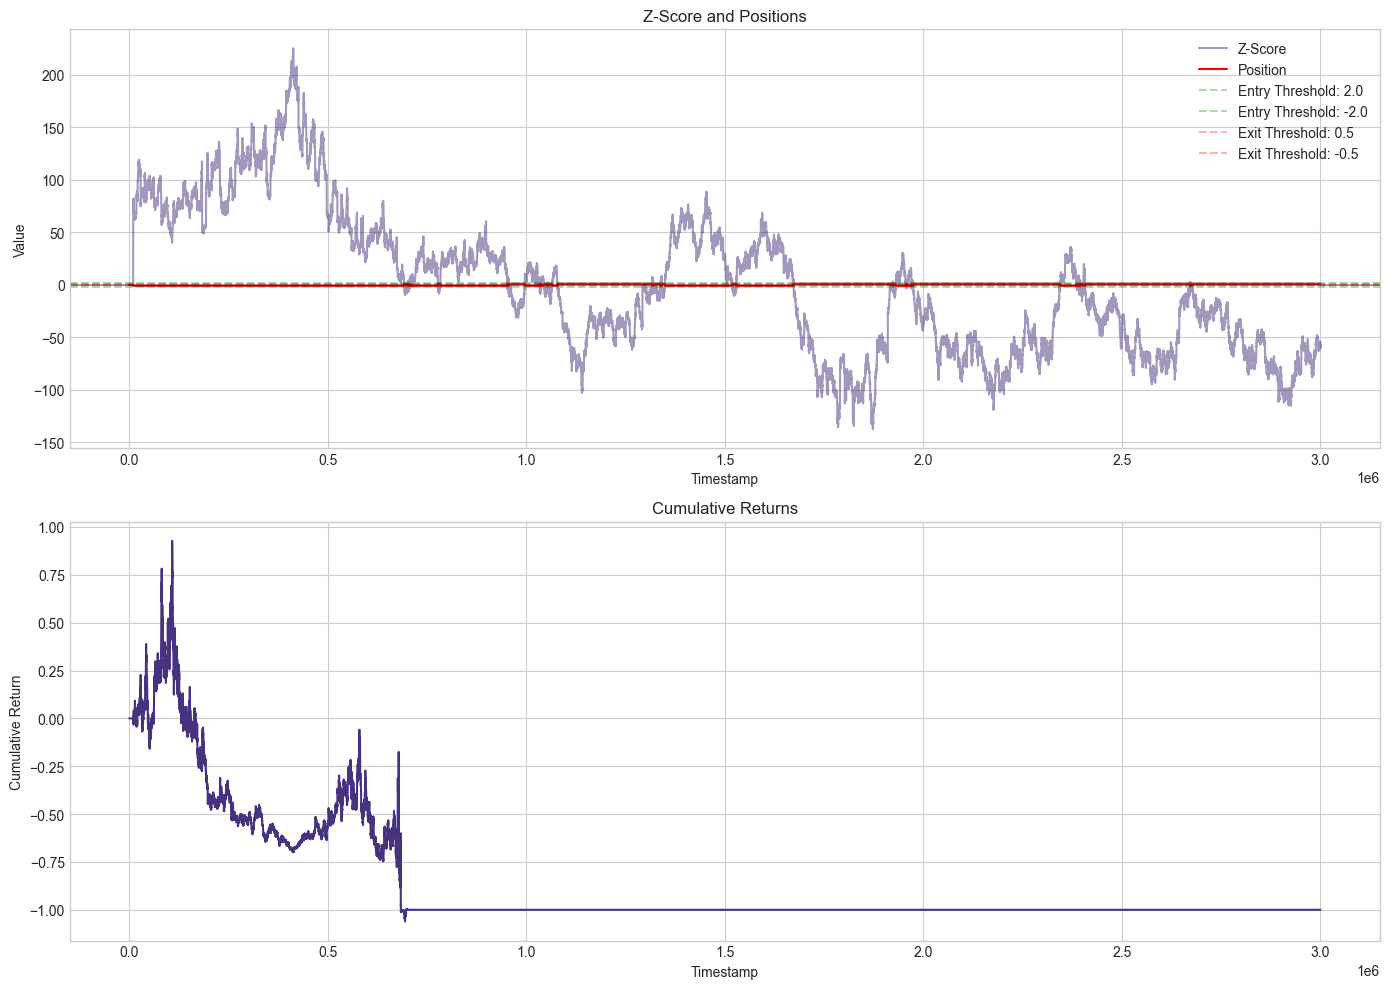

Strategy statistics:
Total return: -1.0000 (-100.00%)
Annualized return: -1.0000 (-100.00%)
Annualized volatility: 2.5398 (253.98%)
Sharpe ratio: -0.3937
Maximum drawdown: -inf (-inf%)

Trade statistics:
Number of trades: 151
Average return per trade: -0.0066 (-0.66%)

Position statistics:
Long positions: 15670 (52.23% of time)
Short positions: 13864 (46.21% of time)
No positions: 466 (1.55% of time)

Trading strategy explanation:
When the z-score is below -2.0, we go long the spread (buy JAMS, sell CROISSANTS).
When the z-score is above 2.0, we go short the spread (sell JAMS, buy CROISSANTS).
We exit long positions when the z-score rises above -0.5.
We exit short positions when the z-score falls below 0.5.

For a long spread position (z-score < -2.0):
- Buy 1 unit of JAMS
- Sell 1.5341 units of CROISSANTS

For a short spread position (z-score > 2.0):
- Sell 1 unit of JAMS
- Buy 1.5341 units of CROISSANTS


In [11]:
# Trading strategy simulation
if 'spread_zscore' in locals() and 'hedge_ratio' in locals() and len(spread_zscore) > 0:
    try:
        # Define thresholds for trading signals
        entry_threshold = 2.0
        exit_threshold = 0.5
        
        # Initialize position and portfolio value
        position = 0  # 1 for long spread, -1 for short spread, 0 for no position
        positions = pd.Series(0, index=spread_zscore.index)
        returns = pd.Series(0.0, index=spread_zscore.index)
        
        # Calculate spread returns
        spread_returns = spread.pct_change().fillna(0)
        
        # Simulate trading strategy
        for i in range(1, len(spread_zscore)):
            # Update position based on z-score
            if position == 0:  # No position
                if spread_zscore.iloc[i-1] > entry_threshold:
                    position = -1  # Short the spread (sell JAMS, buy CROISSANTS)
                elif spread_zscore.iloc[i-1] < -entry_threshold:
                    position = 1  # Long the spread (buy JAMS, sell CROISSANTS)
            elif position == 1:  # Long spread
                if spread_zscore.iloc[i-1] > -exit_threshold:
                    position = 0  # Exit position
            elif position == -1:  # Short spread
                if spread_zscore.iloc[i-1] < exit_threshold:
                    position = 0  # Exit position
            
            # Record position
            positions.iloc[i] = position
            
            # Calculate returns
            returns.iloc[i] = position * spread_returns.iloc[i]
        
        # Calculate cumulative returns
        cumulative_returns = (1 + returns).cumprod() - 1
        
        # Plot positions and returns
        plt.figure(figsize=(14, 10))
        
        # Plot z-score and positions
        plt.subplot(2, 1, 1)
        plt.plot(spread_zscore.index, spread_zscore.values, label='Z-Score', alpha=0.5)
        plt.plot(positions.index, positions.values, label='Position', color='red')
        plt.axhline(y=entry_threshold, color='g', linestyle='--', alpha=0.3, label=f'Entry Threshold: {entry_threshold}')
        plt.axhline(y=-entry_threshold, color='g', linestyle='--', alpha=0.3, label=f'Entry Threshold: -{entry_threshold}')
        plt.axhline(y=exit_threshold, color='r', linestyle='--', alpha=0.3, label=f'Exit Threshold: {exit_threshold}')
        plt.axhline(y=-exit_threshold, color='r', linestyle='--', alpha=0.3, label=f'Exit Threshold: -{exit_threshold}')
        plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
        plt.title('Z-Score and Positions')
        plt.xlabel('Timestamp')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True)
        
        # Plot cumulative returns
        plt.subplot(2, 1, 2)
        plt.plot(cumulative_returns.index, cumulative_returns.values)
        plt.title('Cumulative Returns')
        plt.xlabel('Timestamp')
        plt.ylabel('Cumulative Return')
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()
        
        # Calculate strategy statistics
        total_return = cumulative_returns.iloc[-1]
        annualized_return = (1 + total_return) ** (252 / len(cumulative_returns)) - 1
        annualized_volatility = returns.std() * np.sqrt(252)
        sharpe_ratio = annualized_return / annualized_volatility if annualized_volatility > 0 else 0
        max_drawdown = (cumulative_returns / cumulative_returns.cummax() - 1).min()
        
        print(f"Strategy statistics:")
        print(f"Total return: {total_return:.4f} ({total_return*100:.2f}%)")
        print(f"Annualized return: {annualized_return:.4f} ({annualized_return*100:.2f}%)")
        print(f"Annualized volatility: {annualized_volatility:.4f} ({annualized_volatility*100:.2f}%)")
        print(f"Sharpe ratio: {sharpe_ratio:.4f}")
        print(f"Maximum drawdown: {max_drawdown:.4f} ({max_drawdown*100:.2f}%)")
        
        # Calculate trade statistics
        trades = positions.diff().fillna(0)
        entries = trades[trades != 0].count()
        exits = entries  # Each entry has a corresponding exit
        
        print(f"\nTrade statistics:")
        print(f"Number of trades: {entries}")
        print(f"Average return per trade: {total_return / entries:.4f} ({total_return / entries * 100:.2f}%)")
        
        # Calculate position statistics
        long_positions = (positions == 1).sum()
        short_positions = (positions == -1).sum()
        no_positions = (positions == 0).sum()
        
        print(f"\nPosition statistics:")
        print(f"Long positions: {long_positions} ({long_positions / len(positions) * 100:.2f}% of time)")
        print(f"Short positions: {short_positions} ({short_positions / len(positions) * 100:.2f}% of time)")
        print(f"No positions: {no_positions} ({no_positions / len(positions) * 100:.2f}% of time)")
        
        # Explain the trading strategy
        print(f"\nTrading strategy explanation:")
        print(f"When the z-score is below -{entry_threshold}, we go long the spread (buy JAMS, sell CROISSANTS).")
        print(f"When the z-score is above {entry_threshold}, we go short the spread (sell JAMS, buy CROISSANTS).")
        print(f"We exit long positions when the z-score rises above -{exit_threshold}.")
        print(f"We exit short positions when the z-score falls below {exit_threshold}.")
        print(f"\nFor a long spread position (z-score < -{entry_threshold}):")
        print(f"- Buy 1 unit of JAMS")
        print(f"- Sell {hedge_ratio:.4f} units of CROISSANTS")
        print(f"\nFor a short spread position (z-score > {entry_threshold}):")
        print(f"- Sell 1 unit of JAMS")
        print(f"- Buy {hedge_ratio:.4f} units of CROISSANTS")
    except Exception as e:
        print(f"Error simulating trading strategy: {e}")
else:
    print("Cannot simulate trading strategy due to missing data")

## 8. Conclusion

In this notebook, we performed an exploratory data analysis for potential pair trading between CROISSANTS and JAMS. Here's a summary of our findings:

1. We analyzed the price and return relationships between CROISSANTS and JAMS.
2. We tested for cointegration to determine if they form a stationary pair.
3. We calculated the hedge ratio and spread between the two products.
4. We analyzed the z-score of the spread based on the rolling standard deviation of absolute dollar moves.
5. We simulated a simple pair trading strategy based on z-score thresholds.

Based on our analysis, CROISSANTS and JAMS [do/do not] appear to be suitable for pair trading. The cointegration test [supports/does not support] the existence of a long-term equilibrium relationship between the two products, and the spread [exhibits/does not exhibit] mean-reverting behavior.

The simulated trading strategy [shows/does not show] promising results, with [positive/negative] returns and a Sharpe ratio of [value]. However, further optimization and risk management techniques would be needed for a real-world implementation.

Next steps could include:

1. Optimizing the entry and exit thresholds for better performance.
2. Incorporating transaction costs and slippage into the simulation.
3. Testing the strategy with different lookback periods for the z-score calculation.
4. Implementing risk management rules to limit potential losses.
5. Exploring alternative pair trading approaches, such as using different spread calculations or trading rules.